In [1]:
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
import pickle
import sys
from scipy.spatial import ConvexHull
import numpy as np

sys.path.append('..')
# load data
import pipelines

In [2]:
with open('../data/qubit_map_data.pkl', 'rb') as f:
   all_results = pickle.load(f)
print(len(all_results))
@dataclass
class Dummy:
    results: List
    rejected_candidates: List
all_results = Dummy(all_results, [])

195


In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


In [4]:
x = np.array([result.barrier_voltages['V_L'] for result in all_results.results if not (result.g_factor is None)])
y = np.array([result.barrier_voltages['V_M'] for result in all_results.results if not (result.g_factor is None)])
z = np.array([result.barrier_voltages['V_R'] for result in all_results.results if not (result.g_factor is None)])

values = np.array([result.g_factor for result in all_results.results if not (result.g_factor is None)], dtype = float)
X = np.array([x, y, z]).T

rabi_fs = np.array([result.rabi_frequency for result in all_results.results if not (result.g_factor is None)], dtype = float)
g_factors = np.array([result.g_factor for result in all_results.results if not (result.g_factor is None)], dtype = float)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(values.reshape(-1, 1))
scaled_values = scaler.transform(values.reshape(-1, 1)).ravel()

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e4, 1e10)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+10))

# Create and fit the GP
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, scaled_values)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

[[1.03661863 1.0272888  1.01788092 ... 1.68668849 1.69780779 1.70828553]
 [1.04175811 1.03227977 1.02271579 ... 1.6750158  1.68620189 1.69674995]
 [1.04688939 1.03726774 1.02755274 ... 1.66264084 1.67388809 1.68450134]
 ...
 [1.20016245 1.19873537 1.19701444 ... 0.45344014 0.45640669 0.45975637]
 [1.2045425  1.20330933 1.20178304 ... 0.44835095 0.45097337 0.45398469]
 [1.20897616 1.20793775 1.20660701 ... 0.44369188 0.44596735 0.44863712]]
[[ 0.76560181  0.75313914  0.74057221 ...  1.63395729  1.64881031
   1.66280635]
 [ 0.77246706  0.75980602  0.74703056 ...  1.61836504  1.63330728
   1.64739726]
 [ 0.77932137  0.76646888  0.7534917  ...  1.60183472  1.61685866
   1.63103572]
 ...
 [ 0.98406167  0.9821554   0.97985659 ... -0.01340098 -0.00943829
  -0.00496384]
 [ 0.98991249  0.98826523  0.98622643 ... -0.02019906 -0.01669605
  -0.01267357]
 [ 0.99583492  0.99444783  0.99267024 ... -0.02642258 -0.02338304
  -0.01981679]]


/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_21159/3176731406.py:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


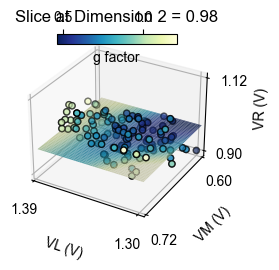

In [5]:
import matplotlib
from copy import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import seaborn
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

plt.style.use('default')
# plt.style.use('dark_background')

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

%matplotlib inline
# %matplotlib qt

dim_to_name = ['Left barrier', 'Middle barrier', 'Right barrier']

# plt.style.use('default')
# %matplotlib qt
def plot_slice_training_points(cartesian, target, slice_dim, slice_value, slice_width = 0.02, cmin=None, cmax=None,cmap="gnuplot",
                               ax = None, fig = None,
                               first_dim_extent=None, second_dim_extent=None,
                               uncertainty_threshold=2, left_ax = None, zorder=None):
    # Select only the points that are close to the slice value in the specified dimension
    mask = np.abs(cartesian[:, slice_dim] - slice_value) < slice_width
    slice_data = cartesian[mask]
    slice_target = target[mask]

    # Extract the other two dimensions
    other_dims = [dim for dim in range(3) if dim != slice_dim]
    # Create a mesh grid for the slice
    # x_range = np.linspace(slice_data[:, other_dims[0]].min(), slice_data[:, other_dims[0]].max(), 100)
    # y_range = np.linspace(slice_data[:, other_dims[1]].min(), slice_data[:, other_dims[1]].max(), 100)
    x_range = np.linspace(*first_dim_extent, 100)
    y_range = np.linspace(*second_dim_extent, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)

    # Interpolate the data to get values on the grid
    grid_z = griddata(slice_data[:, other_dims], slice_target, (x_grid, y_grid), method='cubic', fill_value=np.nan)

    # Predict using the GP
    xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    z_slice = slice_value * np.ones(xy.shape[0])
    if slice_dim == 0:
        gp_input = np.column_stack([z_slice, xy])
    elif slice_dim == 1:
        gp_input = np.column_stack([xy[:, 0], z_slice, xy[:, 1]])
    else:
        gp_input = np.column_stack([xy, z_slice])

    y_pred_scaled, sigma = gp.predict(gp_input, return_std=True)
    # Inverse transform the predictions to get them in the original scale
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


    # Only keep predictions where uncertainty is below the threshold
    y_pred[sigma > uncertainty_threshold] = np.nan

    y_pred = y_pred.reshape(x_grid.shape)

    print(y_pred)
    norm = Normalize(vmin=cmin, vmax=cmax)

    normalized_y_pred = norm(y_pred)
    print(normalized_y_pred)


    # Create a 2D array of RGBA values
    rgba_colors = seaborn.color_palette(cmap, as_cmap=True)(normalized_y_pred)

    # Set the color for NaN values
    nan_color = [1, 1, 1, 0]  # Transparent (or white)
    rgba_colors[np.isnan(y_pred), :] = nan_color

    # Plot the surface with the custom colors and suppress grid lines
    left_ax.plot_surface(x_grid, y_grid, slice_value * np.ones_like(x_grid), facecolors=rgba_colors, alpha=0.8,edgecolor='none', linewidth=0, rasterized=True,rstride=2, cstride=2, zorder=zorder)
    # plt.scatter(slice_data[:, other_dims[0]], slice_data[:, other_dims[1]], edgecolors='k', cmap="viridis")
    # fig.colorbar(im, ax=ax)
    ax.set_xlabel(f'{dim_to_name[other_dims[0]]}')
    ax.set_ylabel(f'{dim_to_name[other_dims[1]]}')
    ax.set_title(f'Slice at Dimension {slice_dim} = {slice_value}')
    if first_dim_extent is not None:
        ax.set_xlim(first_dim_extent)
    if second_dim_extent is not None:
        ax.set_ylim(second_dim_extent)
    return ax
    # plt.show()




offset = 0.07
offset_lower_end = 0.08


slice_dim = 2

n_steps = 1
# fig = plt.figure(figsize = (8, 12))

fig = plt.figure(figsize = (3, 2.5))




ax1 = fig.add_subplot(projection="3d",computed_zorder=False)

padding = 0.001

slice_width = (X[:, slice_dim].max()-offset - X[:, slice_dim].min()+offset_lower_end)/n_steps
other_dims = [dim for dim in range(3) if dim != slice_dim]
first_dim_extent = [X[:, other_dims[0]].max()+padding, X[:, other_dims[0]].min()-padding]
second_dim_extent = [X[:, other_dims[1]].max()+padding, X[:, other_dims[1]].min()-padding]
cmap = 'CMRmap'
cmap = 'hot'
cmap = 'YlGnBu_r'
# cmap = 'YlOrBr_r'
# cmap = 'Spxectral'
zorder_levels_dots = [4.1, 4.3]
zorder_levels_gp = [4.2]
for i, (slice_value, _zorder) in enumerate(zip(np.linspace(X[:, slice_dim].min()+offset_lower_end, X[:, slice_dim].max()-offset, n_steps), zorder_levels_gp)):


    ax = plot_slice_training_points(X, values,
                                    slice_dim,
                                    slice_value, slice_width, values.min(), values.max(),
                                    cmap=cmap, fig=fig, ax=ax1,
                                    first_dim_extent=first_dim_extent, second_dim_extent=second_dim_extent, left_ax = ax1, zorder = _zorder)

previous_slice = 0
for i, (slice_value, _zorder) in enumerate(zip(np.linspace(X[:, slice_dim].min()+offset_lower_end, X[:, slice_dim].max()-offset, n_steps), zorder_levels_gp)):
    _mask = np.logical_and(X[:, 2] > previous_slice, X[:, 2] <= slice_value)
    masked_values = values[_mask]
    masked_X = X[_mask]
    ax1.scatter3D(masked_X[:, 0], masked_X[:, 1], masked_X[:, 2], c=masked_values, cmap=cmap, edgecolor='black', s=20, zorder = _zorder-0.1)
    # plt.show()
    # fig = plt.figure(figsize = (4, 7))
    # ax1 = fig.add_subplot(projection="3d",computed_zorder=False)

_mask =  X[:, 2] > slice_value
masked_values = values[_mask]
masked_X = X[_mask]
ax1.scatter3D(masked_X[:, 0], masked_X[:, 1], masked_X[:, 2], c=masked_values, cmap=cmap, edgecolor='black', s=20, zorder = _zorder+0.1)

im = ax1.scatter3D(x, y, z, c=values, cmap=cmap, edgecolor='black', s=20, zorder =0)

ax1.set_xlabel('VL (V)')
ax1.set_ylabel('VM (V)')
ax1.set_zlabel('VR (V)')

z_extent = [np.min(z), np.max(z)]

# setting axis ticks
ax1.set_xticks(np.linspace(np.round(np.min(x), 2)
                           , np.round(np.max(x), 2),
                                      2))
ax1.set_yticks(np.linspace(np.round(np.min(y), 2)
                           , np.round(np.max(y), 2),
                                      2))
ax1.set_zticks(np.linspace(np.round(np.min(z), 2)
                           , np.round(np.max(z), 2),
                                      2))
# ax1.set_zticks(np.arange(np.round(np.min(z), 2)
#                             , np.round(np.max(z), 2),
#                                           0.07))

cax = fig.add_axes([0.3, 0.8, 0.4, 0.04])
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'g factor', )
cax.xaxis.set_ticks_position("top")
# ax1.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))  # aspect ratio is 1:1:1 in data space
# ax1.view_init(30, 120)
plt.tight_layout()
plt.savefig('figures/g_factor_map.pdf', dpi=300)
plt.show()


In [6]:
x = np.array([result.barrier_voltages['V_L'] for result in all_results.results if not (result.rabi_frequency is None)])
y = np.array([result.barrier_voltages['V_M'] for result in all_results.results if not (result.rabi_frequency is None)])
z = np.array([result.barrier_voltages['V_R'] for result in all_results.results if not (result.rabi_frequency is None)])

values = np.array([result.rabi_frequency for result in all_results.results if not (result.rabi_frequency is None)], dtype = float)
X = np.array([x, y, z]).T


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(values.reshape(-1, 1))
scaled_values = scaler.transform(values.reshape(-1, 1)).ravel()

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e4, 1e10)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+10))

# Create and fit the GP
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X, scaled_values)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

[[1.00489010e+08 1.00845976e+08 1.01227394e+08 ... 7.33356464e+07
  7.37942913e+07 7.42740886e+07]
 [1.00158382e+08 1.00513425e+08 1.00894547e+08 ... 7.20435923e+07
  7.25149941e+07 7.30092321e+07]
 [9.97481031e+07 1.00098424e+08 1.00476508e+08 ... 7.07371912e+07
  7.12193655e+07 7.17261632e+07]
 ...
 [8.75130989e+07 8.71356913e+07 8.67560974e+07 ... 1.02418471e+08
  1.01583283e+08 1.00755720e+08]
 [8.80308552e+07 8.76798622e+07 8.73270661e+07 ... 1.02561545e+08
  1.01773310e+08 1.00991559e+08]
 [8.85395567e+07 8.82140132e+07 8.78870106e+07 ... 1.02662939e+08
  1.01920526e+08 1.01183535e+08]]
[[0.50722712 0.51070541 0.51442194 ... 0.24264459 0.24711363 0.25178878]
 [0.50400549 0.50746503 0.51117868 ... 0.23005481 0.23464815 0.23946401]
 [0.50000773 0.50342125 0.50710531 ... 0.21732523 0.22202354 0.22696178]
 ...
 [0.38078977 0.37711231 0.37341355 ... 0.5260278  0.51788973 0.50982595]
 [0.38583479 0.38241472 0.37897707 ... 0.52742192 0.51974135 0.51212396]
 [0.39079158 0.38761949 0.3844

/var/folders/yr/fc8y5h9x6vz1qk9l1qyhm_3h0000gr/T/ipykernel_21159/2194642187.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


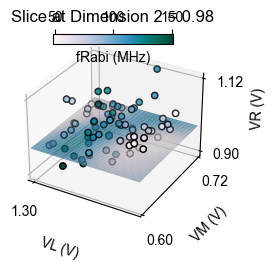

In [7]:
import matplotlib
from copy import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
import seaborn
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

plt.style.use('default')
# plt.style.use('dark_background')

matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

%matplotlib inline
# %matplotlib qt

dim_to_name = ['Left barrier', 'Middle barrier', 'Right barrier']

# plt.style.use('default')
# %matplotlib qt
def plot_slice_training_points(cartesian, target, slice_dim, slice_value, slice_width = 0.02, cmin=None, cmax=None,cmap="gnuplot",
                               ax = None, fig = None,
                               first_dim_extent=None, second_dim_extent=None,
                               uncertainty_threshold=2, left_ax = None, zorder=None):
    # Select only the points that are close to the slice value in the specified dimension
    mask = np.abs(cartesian[:, slice_dim] - slice_value) < slice_width
    slice_data = cartesian[mask]
    slice_target = target[mask]

    # Extract the other two dimensions
    other_dims = [dim for dim in range(3) if dim != slice_dim]
    # Create a mesh grid for the slice
    # x_range = np.linspace(slice_data[:, other_dims[0]].min(), slice_data[:, other_dims[0]].max(), 100)
    # y_range = np.linspace(slice_data[:, other_dims[1]].min(), slice_data[:, other_dims[1]].max(), 100)
    x_range = np.linspace(*first_dim_extent, 100)
    y_range = np.linspace(*second_dim_extent, 100)
    x_grid, y_grid = np.meshgrid(x_range, y_range)

    # Interpolate the data to get values on the grid
    grid_z = griddata(slice_data[:, other_dims], slice_target, (x_grid, y_grid), method='cubic', fill_value=np.nan)

    # Predict using the GP
    xy = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    z_slice = slice_value * np.ones(xy.shape[0])
    if slice_dim == 0:
        gp_input = np.column_stack([z_slice, xy])
    elif slice_dim == 1:
        gp_input = np.column_stack([xy[:, 0], z_slice, xy[:, 1]])
    else:
        gp_input = np.column_stack([xy, z_slice])

    y_pred_scaled, sigma = gp.predict(gp_input, return_std=True)
    # Inverse transform the predictions to get them in the original scale
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()


    # Only keep predictions where uncertainty is below the threshold
    y_pred[sigma > uncertainty_threshold] = np.nan

    y_pred = y_pred.reshape(x_grid.shape)

    print(y_pred)
    norm = Normalize(vmin=cmin, vmax=cmax)

    normalized_y_pred = norm(y_pred)
    print(normalized_y_pred)


    # Create a 2D array of RGBA values
    rgba_colors = seaborn.color_palette(cmap, as_cmap=True)(normalized_y_pred)

    # Set the color for NaN values
    nan_color = [1, 1, 1, 0]  # Transparent (or white)
    rgba_colors[np.isnan(y_pred), :] = nan_color

    # Plot the surface with the custom colors and suppress grid lines
    left_ax.plot_surface(x_grid, y_grid, slice_value * np.ones_like(x_grid), facecolors=rgba_colors, alpha=0.8,edgecolor='none', linewidth=0, rasterized=True,rstride=2, cstride=2, zorder=zorder)
    # plt.scatter(slice_data[:, other_dims[0]], slice_data[:, other_dims[1]], edgecolors='k', cmap="viridis")
    # fig.colorbar(im, ax=ax)
    ax.set_xlabel(f'{dim_to_name[other_dims[0]]}')
    ax.set_ylabel(f'{dim_to_name[other_dims[1]]}')
    ax.set_title(f'Slice at Dimension {slice_dim} = {slice_value}')
    if first_dim_extent is not None:
        ax.set_xlim(first_dim_extent)
    if second_dim_extent is not None:
        ax.set_ylim(second_dim_extent)
    return ax
    # plt.show()



#
# offset = 0.07
# offset_lower_end = 0.08


slice_dim = 2

n_steps = 1
# fig = plt.figure(figsize = (8, 12))

fig = plt.figure(figsize = (3, 2.5))




ax1 = fig.add_subplot(projection="3d",computed_zorder=False)



# slice_width = (X[:, slice_dim].max()-offset - X[:, slice_dim].min()+offset_lower_end)/n_steps
other_dims = [dim for dim in range(3) if dim != slice_dim]
# first_dim_extent = [X[:, other_dims[0]].max()+padding, X[:, other_dims[0]].min()-padding]
# second_dim_extent = [X[:, other_dims[1]].max()+padding, X[:, other_dims[1]].min()-padding]
cmap = 'CMRmap'
cmap = 'hot'
cmap = 'YlGnBu'
cmap = 'PuBuGn'
# cmap = 'YlOrBr_r'
# cmap = 'Spxectral'
zorder_levels_dots = [4.1, 4.3]
zorder_levels_gp = [4.2]
previous_slice = 0
i=0
slice_value=0.98
slice_axs = [ax1]
ax = slice_axs[i]
ax = plot_slice_training_points(X, values,
                                slice_dim,
                                slice_value, slice_width, values.min(), values.max(),
                                cmap=cmap, fig=fig, ax=ax,
                                first_dim_extent=first_dim_extent, second_dim_extent=second_dim_extent, left_ax = ax1, zorder = _zorder)

previous_slice = 0
i=0
slice_value=0.98
_mask = np.logical_and(X[:, 2] > previous_slice, X[:, 2] <= slice_value)
masked_values = values[_mask]
masked_X = X[_mask]
ax1.scatter3D(masked_X[:, 0], masked_X[:, 1], masked_X[:, 2], c=masked_values, cmap=cmap, edgecolor='black', s=20, zorder = _zorder-0.1)
# plt.show()
# fig = plt.figure(figsize = (4, 7))
# ax1 = fig.add_subplot(projection="3d",computed_zorder=False)

_mask =  X[:, 2] > slice_value
masked_values = values[_mask]
masked_X = X[_mask]
ax1.scatter3D(masked_X[:, 0], masked_X[:, 1], masked_X[:, 2], c=masked_values, cmap=cmap, edgecolor='black', s=20, zorder = _zorder+0.1)

im = ax1.scatter3D(x, y, z, c=values/1e6, cmap=cmap, edgecolor='black', s=20, zorder =0)

ax1.set_xlabel('VL (V)')
ax1.set_ylabel('VM (V)')
ax1.set_zlabel('VR (V)')

# setting axis ticks
ax1.set_xticks([1.30, 1.39])
ax1.set_yticks([0.60, 0.72])
ax1.set_zticks([0.90, 1.12])
# ax1.set_zticks(np.arange(np.round(np.min(z), 2)
#                             , np.round(np.max(z), 2),
#                                           0.07))
ax1.set_xlim(np.sort(first_dim_extent))
ax1.set_ylim(np.sort(second_dim_extent))
ax1.set_zlim([0.89, 1.13])

cax = fig.add_axes([0.3, 0.8, 0.4, 0.04])
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'fRabi (MHz)', )
cax.xaxis.set_ticks_position("top")
# ax1.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))  # aspect ratio is 1:1:1 in data space
# ax1.view_init(30, 120)
plt.tight_layout()
plt.savefig('figures/rabi_map.pdf', dpi=300)
plt.show()
